In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dyflownet as dfn

## Two Cells

### Ignore Queue in Source

In [2]:
state_len = 51

net_0 = dfn.net.Network(ID = 'net_0', state_len = state_len, num_step = 500, time_step_size = 0.1)

source_0 = dfn.cell.Source(ID = 'source_0', initial_condition = {'density': [0]*state_len}, 
                           boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=0.8),
                           sending = dfn.flow.BufferSendingFlow(demand=0.8, capacity=1, ignore_queue=True))

sink_0 = dfn.cell.Sink(ID = 'sink_0', max_density = 5, max_speed = 1, 
                       initial_condition = {'density': np.linspace(0, 5, state_len)}, 
                       receiving = dfn.flow.PiecewiseLinearReceivingFlow(congestion_wave_speed=0.25, max_density=5, capacity=1),
                       boundary_outflow = dfn.flow.BoundaryOutflow(boundary_speed=1, boundary_capacity=1))

junction_0 = dfn.node.BasicJunction(ID='node_0', incoming_cell_list=[source_0], outgoing_cell_list=[sink_0])

net_0.add_cell('source', source_0)
net_0.add_cell('sink', sink_0)
net_0.add_node(junction_0)

net_0.run()

source_0 initialized.
sink_0 initialized.
node_0 initialized.
time cost: 0.1 seconds.


In [3]:
num_x_grid, num_y_grid = 21, 26

X, Y = np.meshgrid(np.linspace(0, 2, num_x_grid), np.linspace(0, 5, num_y_grid), indexing='ij')

inflow_source_0 = source_0.flow_dict['boundary_inflow'].compute_flow() * np.ones([num_x_grid, num_y_grid])
sending_source_0 = source_0.flow_dict['sending'].compute_flow()

receiving_sink_0 = sink_0.flow_dict['receiving'].compute_flow(Y)
outflow_sink_0 = sink_0.flow_dict['boundary_outflow'].compute_flow(Y)

inter_cell_flow = junction_0.compute_inter_cell_flow([sending_source_0], [receiving_sink_0])[0]

U = inflow_source_0 - inter_cell_flow
V = inter_cell_flow - outflow_sink_0

norm = np.sqrt(U**2+V**2)

U_normed = np.divide(U, norm, out=np.zeros_like(U), where=norm!=0)
V_normed = np.divide(V, norm, out=np.zeros_like(V), where=norm!=0)

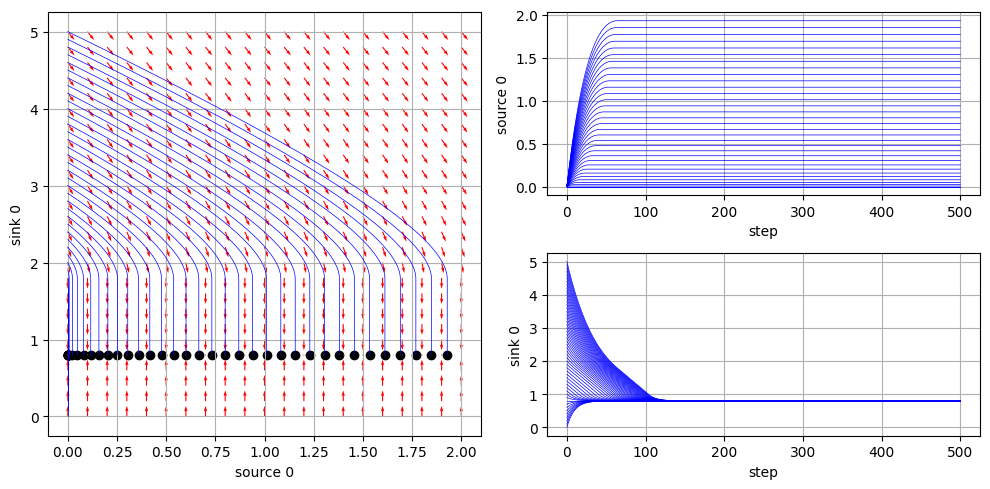

In [4]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(source_0.state_output['density'][-1, :], sink_0.state_output['density'][-1, :], color='k')
plt.plot(source_0.state_output['density'], sink_0.state_output['density'], 'b-', linewidth=0.5)
plt.quiver(X, Y, U_normed, V_normed, color='red')
plt.xlabel('source 0')
plt.ylabel('sink 0')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(source_0.state_output['density'], 'b-', linewidth=0.5)
plt.xlabel('step')
plt.ylabel('source 0')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(sink_0.state_output['density'], 'b-', linewidth=0.5)
plt.xlabel('step')
plt.ylabel('sink 0')
plt.grid()


plt.tight_layout()

plt.show()

### Consider Queue in Source

In [5]:
state_len = 51

net_0 = dfn.net.Network(ID='net_0', state_len = state_len, num_step=1000, time_step_size=0.1)

source_0 = dfn.cell.Source(ID = 'source_0', initial_condition = {'density': [0]*state_len}, 
                           boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=0.8),
                           sending = dfn.flow.BufferSendingFlow(demand=0.8, capacity=1, ignore_queue=False))

sink_0 = dfn.cell.Sink(ID = 'sink_0', max_density = 5, max_speed = 1,
                       initial_condition = {'density': np.linspace(0, 5, state_len)}, 
                       receiving = dfn.flow.PiecewiseLinearReceivingFlow(congestion_wave_speed=0.25, max_density=5, capacity=1),
                       boundary_outflow = dfn.flow.BoundaryOutflow(boundary_speed=1, boundary_capacity=1))

junction_0 = dfn.node.BasicJunction(ID='node_0', incoming_cell_list=[source_0], outgoing_cell_list=[sink_0])

net_0.add_cell('source', source_0)
net_0.add_cell('sink', sink_0)

net_0.add_node(junction_0)

net_0.run()

source_0 initialized.
sink_0 initialized.
node_0 initialized.
time cost: 0.1 seconds.


In [6]:
num_x_grid, num_y_grid = 21, 26

X, Y = np.meshgrid(np.linspace(0, 2, num_x_grid), np.linspace(0, 5, num_y_grid), indexing='ij')

inflow_source_0 = source_0.flow_dict['boundary_inflow'].compute_flow() * np.ones([num_x_grid, num_y_grid])
sending_source_0 = source_0.flow_dict['sending'].compute_flow(queue_len = X)

receiving_sink_0 = sink_0.flow_dict['receiving'].compute_flow(Y)
outflow_sink_0 = sink_0.flow_dict['boundary_outflow'].compute_flow(Y)

inter_cell_flow = junction_0.compute_inter_cell_flow([sending_source_0], [receiving_sink_0])[0]

U = inflow_source_0 - inter_cell_flow
V = inter_cell_flow - outflow_sink_0

norm = np.sqrt(U**2+V**2)

U_normed = np.divide(U, norm, out=np.zeros_like(U), where=norm!=0)
V_normed = np.divide(V, norm, out=np.zeros_like(V), where=norm!=0)

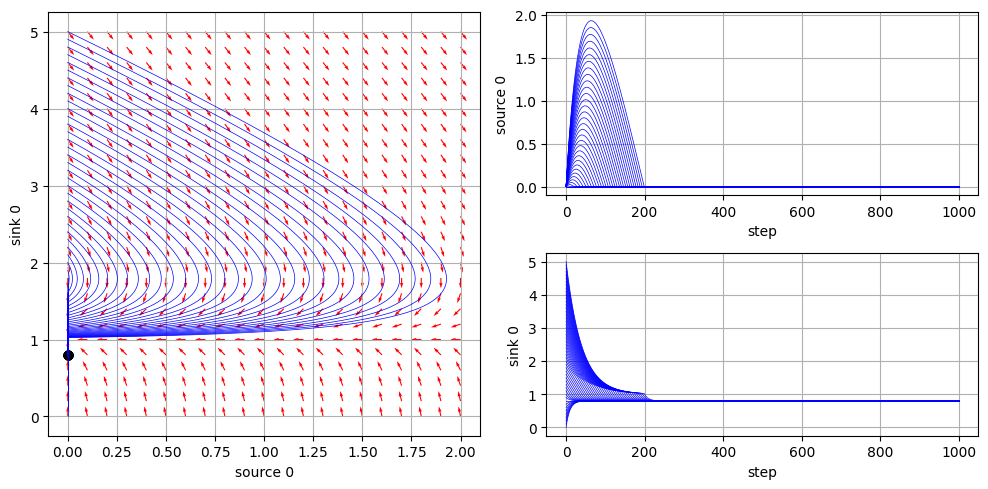

In [7]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(source_0.state_output['density'][-1, :], sink_0.state_output['density'][-1, :], color='k')
plt.plot(source_0.state_output['density'], sink_0.state_output['density'], 'b-', linewidth=0.5)
plt.quiver(X, Y, U_normed, V_normed, color='red')
plt.xlabel('source 0')
plt.ylabel('sink 0')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(source_0.state_output['density'], 'b-', linewidth=0.5)
plt.xlabel('step')
plt.ylabel('source 0')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(sink_0.state_output['density'], 'b-', linewidth=0.5)
plt.xlabel('step')
plt.ylabel('sink 0')
plt.grid()

plt.tight_layout()

plt.show()

## Three Cells


In [8]:
initial_condition = dfn.utils.generate_boundary_combos(np.linspace(0, 5, 26), np.linspace(0, 5, 26))

state_len = len(initial_condition[0, :])

net_0 = dfn.net.Network(ID='net_0', state_len = state_len, num_step = 5000, time_step_size = 0.1)

source_0 = dfn.cell.Source(ID = 'source_0',
                           initial_condition = {'density': [0]*state_len}, 
                           boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=0.8),
                           sending = dfn.flow.BufferSendingFlow(demand=0.8, capacity=1, ignore_queue=True),
                          )

link_0 = dfn.cell.Link(ID = 'link_0',
                       initial_condition = {'density': initial_condition[0, :]},
                       receiving = dfn.flow.PiecewiseLinearReceivingFlow(congestion_wave_speed=0.25, max_density=5, capacity=1),
                       sending = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=1, capacity=1),
                      )


sink_0 = dfn.cell.Sink(ID = 'sink_0', max_density = 5, max_speed = 1,
                       initial_condition = {'density': initial_condition[1, :]}, 
                       receiving = dfn.flow.PiecewiseLinearReceivingFlow(congestion_wave_speed=0.25, max_density=5, capacity=1),
                       boundary_outflow = dfn.flow.BoundaryOutflow(boundary_speed=1, boundary_capacity=1),
                      )

junction_0 = dfn.node.BasicJunction(ID='node_0', incoming_cell_list=[source_0], outgoing_cell_list=[link_0])

junction_1 = dfn.node.BasicJunction(ID='node_1', incoming_cell_list=[link_0], outgoing_cell_list=[sink_0])


net_0.add_cell('source', source_0)
net_0.add_cell('link', link_0)
net_0.add_cell('sink', sink_0)

net_0.add_node(junction_0)
net_0.add_node(junction_1)

net_0.run()

source_0 initialized.
link_0 initialized.
sink_0 initialized.
node_0 initialized.
node_1 initialized.
time cost: 0.8 seconds.


In [9]:
num_x_grid, num_y_grid = 26, 26

X, Y = np.meshgrid(np.linspace(0, 5, num_x_grid), np.linspace(0, 5, num_y_grid), indexing='ij')

sending_source_0 = source_0.flow_dict['sending'].compute_flow()

receiving_link_0 = link_0.flow_dict['receiving'].compute_flow(X)
sending_link_0 = link_0.flow_dict['sending'].compute_flow(X)

receiving_sink_0 = sink_0.flow_dict['receiving'].compute_flow(Y)
outflow_sink_0 = sink_0.flow_dict['boundary_outflow'].compute_flow(Y)


inter_cell_flow_0 = junction_0.compute_inter_cell_flow([sending_source_0], [receiving_link_0])[0]

inter_cell_flow_1 = junction_1.compute_inter_cell_flow([sending_link_0], [receiving_sink_0])[0]

U = inter_cell_flow_0 - inter_cell_flow_1
V = inter_cell_flow_1 - outflow_sink_0

norm = np.sqrt(U**2+V**2)

U_normed = np.divide(U, norm, out=np.zeros_like(U), where=norm!=0)
V_normed = np.divide(V, norm, out=np.zeros_like(V), where=norm!=0)

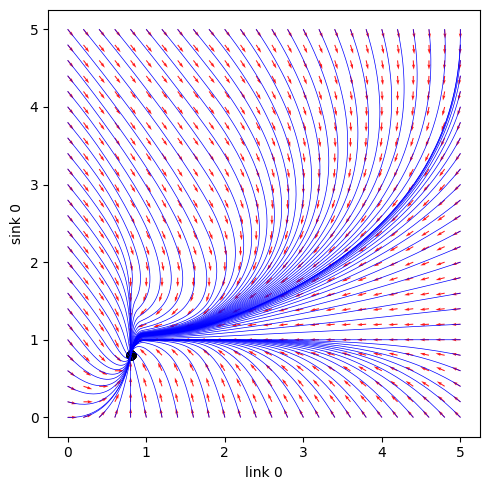

In [10]:
plt.figure(figsize=(5, 5))

plt.scatter(link_0.state_output['density'][-1, :], sink_0.state_output['density'][-1, :], color='k')

plt.plot(link_0.state_output['density'], sink_0.state_output['density'], 'b-', linewidth=0.5)

plt.quiver(X, Y, U_normed, V_normed, color='red', alpha=0.9)

plt.xlabel('link 0')

plt.ylabel('sink 0')

plt.tight_layout()

plt.show()